In [1]:
from transformers import set_seed

# Random number generators seed for reproducibility (same code == same results)
# Set the seed in random, numpy, torch and/or tensorflow if installed
set_seed(22)

In [2]:
import sys
sys.path.append("./docker-python/patches")

In [3]:
# TODO: Change to the new gemma 1.1 versions once they have been tested enough by the community
# gemma_2b = '/kaggle/input/gemma/transformers/2b/2'
# gemma_7b_it = '/kaggle/input/gemma/transformers/7b-it/3'
# gemma_2b_it = '/kaggle/input/gemma/transformers/2b-it/3'

# Model IDs on Hugging Face Hub
gemma_7b = 'google/gemma-7b'
gemma_7b_it = 'google/gemma-7b-it'
gemma_2b_it = 'google/gemma-2b-it'

# Test prompts
prompt_1 = "What is Data Science?"
prompt_2 = "Explain 3 important Data Science concepts, and tell why each concept is important"
prompt_3 = "I'm a marketing specialist, I know nothing about Data Science. Explain to me what Data Science is and simplifie it as much as you can. When possible, use analogies that I can understand better as a marketing specialist"
# These prompts are just a way to test our models and see how they perform depending on the complexity of the task.

In [ ]:
import transformers, tensorflow
import torch

print(transformers.__version__)
print(torch.__version__)
print(tensorflow.__version__)

4.53.0
2.7.0+cpu
2.18.0


In [25]:
from dotenv import load_dotenv
from pathlib import Path

dotenv_path = ".env"

load_dotenv(dotenv_path=dotenv_path)

True

In [26]:
import os
# get your account token from https://huggingface.co/settings/tokens
HUGGINGFACE_TOKEN = os.environ["HUGGINGFACE_TOKEN"]


# import the relavant libraries for loggin in
from huggingface_hub import login

# set api for login and save token
login(token=HUGGINGFACE_TOKEN, add_to_git_credential=True)

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
import torch

def load_model(model_id="google/gemma-2b-it", tokenizer_id="google/gemma-2b-it", load_in_4bit=True, device="auto", quant_compute_dtype=torch.float16, torch_dtype=None):
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=load_in_4bit,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_compute_dtype=quant_compute_dtype,
    ) if load_in_4bit else None

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_id, cache_dir="tmp/model")
    
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=quantization_config,
        device_map=device,
        torch_dtype=torch_dtype,
    )

    return tokenizer, model

# Load
coder_tokenizer, coder_model = load_model()

# Prepare for training
coder_model = prepare_model_for_kbit_training(coder_model)

# LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA
from peft import get_peft_model
coder_model = get_peft_model(coder_model, lora_config)
coder_model.print_trainable_parameters()


The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 9,805,824 || all params: 2,515,978,240 || trainable%: 0.3897


In [16]:
from datasets import load_dataset

# Step 1: Load the dataset
dataset = load_dataset(
    'json',
    data_files="data/dataset_1.1.json",  # Use forward slash for compatibility
    split='train'
)

# Step 2: Filter out long sequences
def _filter(example):
    tokens = coder_tokenizer.apply_chat_template(example['messages'], tokenize=True)
    return len(tokens) <= 1000  # allow space for special tokens

dataset = dataset.filter(_filter)

# Step 3: Shuffle and remove unnecessary columns
dataset = dataset.shuffle(seed=1111)
if 'lang' in dataset.column_names:
    dataset = dataset.remove_columns(['lang'])

# Step 4: Tokenize with labels
def tokenize(example):
    # 1. Format message using chat template
    formatted_text = coder_tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,  # <-- we want the formatted string
        add_generation_prompt=False  # Optional, set to True for instruction tuning
    )

    # 2. Tokenize it to get input_ids and attention_mask
    output = coder_tokenizer(
        formatted_text,
        truncation=True,
        max_length=1024,
        padding="max_length"
    )

    # 3. Mask the padding tokens in labels
    labels = output["input_ids"].copy()
    pad_token_id = coder_tokenizer.pad_token_id or coder_tokenizer.eos_token_id
    labels = [-100 if token_id == pad_token_id else token_id for token_id in labels]

    return {
        "input_ids": output["input_ids"],
        "attention_mask": output["attention_mask"],
        "labels": labels
    }



dataset = dataset.map(tokenize, remove_columns=dataset.column_names)


Map:   0%|          | 0/181 [00:00<?, ? examples/s]

In [17]:
from trl import SFTTrainer, SFTConfig
from transformers import DataCollatorForSeq2Seq

training_args = SFTConfig(
    output_dir="model_training_outputs",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    learning_rate=2e-4,
    weight_decay=0.01,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    fp16=True,
    bf16=False,
    seed=42,
    logging_steps=10,
    save_steps=100,
    save_total_limit=2,
    report_to="none",
    dataset_num_proc=1,
    packing=False,
    max_seq_length=1024,
)

collator = DataCollatorForSeq2Seq(tokenizer=coder_tokenizer, padding=True)

# Step 5: Create trainer
trainer = SFTTrainer(
    model=coder_model,
    train_dataset=dataset,
    data_collator=collator,
    args=training_args,
)


Truncating train dataset:   0%|          | 0/181 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
trainer.train()

Step,Training Loss
10,8.323000
20,4.484400
30,3.705600
40,3.179600
50,3.233700
60,3.087600


TrainOutput(global_step=69, training_loss=4.161116254502448, metrics={'train_runtime': 52984.418, 'train_samples_per_second': 0.01, 'train_steps_per_second': 0.001, 'total_flos': 6644661045166080.0, 'train_loss': 4.161116254502448})

In [22]:
# Step 7: Save model and tokenizer
coder_model.save_pretrained("trained_lora_model_model")
coder_tokenizer.save_pretrained("trained_lora_model_tokenizer")

('trained_lora_model_tokenizer\\tokenizer_config.json',
 'trained_lora_model_tokenizer\\special_tokens_map.json',
 'trained_lora_model_tokenizer\\chat_template.jinja',
 'trained_lora_model_tokenizer\\tokenizer.model',
 'trained_lora_model_tokenizer\\added_tokens.json',
 'trained_lora_model_tokenizer\\tokenizer.json')

In [23]:
# Merge LoRA adapters into the base model
merged_model = coder_model.merge_and_unload()

# Save merged model for inference or sharing
merged_model.save_pretrained("merged_full_model")
coder_tokenizer.save_pretrained("merged_full_model")


d:\03_Development\00_Anaconda\envs\datascience_env_v2\Lib\site-packages\peft\tuners\lora\bnb.py:351: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


('merged_full_model\\tokenizer_config.json',
 'merged_full_model\\special_tokens_map.json',
 'merged_full_model\\chat_template.jinja',
 'merged_full_model\\tokenizer.model',
 'merged_full_model\\added_tokens.json',
 'merged_full_model\\tokenizer.json')

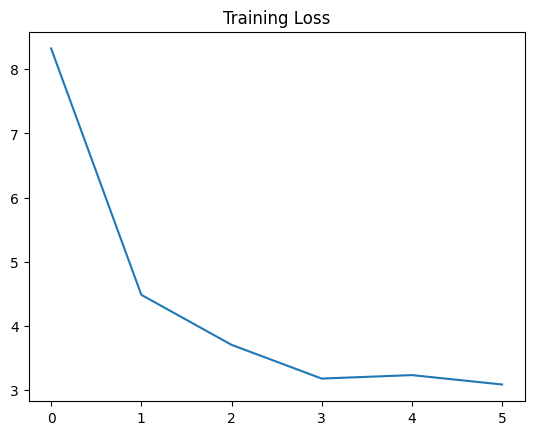

In [19]:
import matplotlib.pyplot as plt

loss = [log['loss'] for log in trainer.state.log_history[:-1]]
plt.title('Training Loss')
plt.plot(loss)